# Applying SVC and SGDClassifier on avg Word2vec

This ipynb file contains the code for-

* GridSearchCV on SVC for avg Word2vec
* RandomizedSearchCV on SVC for avg Word2vec
* GridSearchCV on SGDClassifier for avg Word2vec

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sqlite3
import numpy as np
import pandas as pd

## Loading the data

In [5]:
sample_data=pd.read_csv('sample_svm.csv')

In [30]:
sample_data=sample_data.iloc[:25000]

In [31]:
#taking the test data seperate from all other

X, x_test, y_train, y_test=train_test_split(sample_data['Cleaned_text'], sample_data['Score'], test_size=0.3) #splitting the data

In [48]:
# this function plot mse vs C plot, predicting accuracy, confusion matrix and classification report

def svm_plot(clf, x_train, y_train, x_test, y_test):
          
    #predicting y and accuracy
    y_pred=clf.predict(x_test)
    accu=accuracy_score(y_pred,y_test)*100
    print('accuracy=',accu)
    print('**********************************************************************\n')
    
    #confusion matrix
    t=confusion_matrix(y_pred,y_test)
    print('confusion matrix--')
    #print(t)
    #print('**********************************************************************')
    sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    print('**********************************************************************\n')
    
    # finding TPR , TNR, FPR, FNR
    TNR=t[0][0]/(t[0][0]+t[1][0])
    TPR=t[1][1]/(t[0][1]+t[1][1])
    FPR=t[1][0]/(t[0][0]+t[1][0])
    FNR=t[0][1]/(t[0][1]+t[1][1])
    print('TNR=',TNR)
    print('TPR=',TPR)
    print('FPR=',FPR)
    print('FNR=',FNR)
    print('**********************************************************************\n')
    
    
    #classification report
    print(classification_report(y_pred,y_test))
    print('**********************************************************************\n')
    
    
    return accu, TNR, TPR, FPR, FNR

In [8]:
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [9]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)


2018-09-16 19:46:36,764 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2018-09-16 19:49:33,005 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


In [32]:
#getting the list of sentences in a 'list'
i=0

list_of_sentences=[]
for sent in X.values:
    filtered_sentence=[]    
    for w in sent.split():
        #w=w.decode('utf-8')
        if (w==sent.split()[0]):
            w=w[2:]
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)

In [33]:
words=list(model.wv.vocab)
print(len(words))

3000000


In [34]:
#calculating avg word2vec
vectors=[];
for sentence in list_of_sentences:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence:
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    vectors.append(sentence_vector)

In [35]:
z=list(np.unique(np.where(np.isnan(vectors))[0]))
z

[107,
 547,
 1126,
 3272,
 5252,
 6485,
 6964,
 8540,
 10114,
 11321,
 15172,
 15645,
 16600]

In [36]:
vectors=np.delete(vectors, z, axis=0)
y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)

In [37]:
#calculating avg word2vec
x_test_word=[];
for sentence in x_test.values:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    x_test_word.append(sentence_vector)

In [38]:
#checking row containing nan value
z=list(np.unique(np.where(np.isnan(x_test_word))[0]))
z

[1194, 5151, 5667, 6074]

In [39]:
#deleting row containing nan value
x_test_word=np.delete(x_test_word, z, axis=0)
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)

In [40]:
# applying normalization on every columns
from sklearn.preprocessing import normalize

vectors=normalize(vectors)
x_test_word=normalize(x_test_word)

## Applying GridSearchCV on SVC

In [44]:
from sklearn.svm import SVC

tscv=TimeSeriesSplit(n_splits=10)
gamma=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50], 'gamma':gamma}
clf=SVC()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=-1, verbose=1)

In [45]:
# fitting the model
import pickle
%time
start=datetime.now()
clf.fit(vectors,y_train_word)
pickle.dump(clf,open('svm_avg_grid.p','wb'))
end=datetime.now()
print('duration = ',(end-start))


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs
Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed: 47.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 69.5min finished


duration =  1:11:29.257226


In [47]:
# best value of C
c=clf.best_estimator_.get_params()['C']
gamma=clf.best_estimator_.get_params()['gamma']
print('best C=',c)
print('best penalty=',gamma)

best C= 5
best penalty= 1


accuracy= 90.80843116328708
**********************************************************************

confusion matrix--


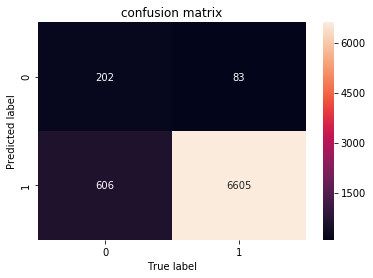

**********************************************************************

TNR= 0.25
TPR= 0.9875897129186603
FPR= 0.75
FNR= 0.012410287081339713
**********************************************************************

             precision    recall  f1-score   support

          0       0.25      0.71      0.37       285
          1       0.99      0.92      0.95      7211

avg / total       0.96      0.91      0.93      7496

**********************************************************************



In [50]:
accu, TNR, TPR, FPR, FNR=svm_plot(clf=clf, x_train=vectors, y_train=y_train_word, x_test=x_test_word, y_test=y_test_word)

## Applying RandomizedSearchCV on SVC

In [53]:
from sklearn.model_selection import RandomizedSearchCV

tscv=TimeSeriesSplit(n_splits=10)
gamma=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
param={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50], 'gamma':gamma}
clf=SVC()
clf=RandomizedSearchCV(estimator=clf, param_distributions=param,cv=tscv,scoring='accuracy', n_jobs=-1)

In [54]:
# fitting the model
import pickle
%time
start=datetime.now()
clf.fit(vectors,y_train_word)
pickle.dump(clf,open('svm_avg_random.p','wb'))
end=datetime.now()
print('duration = ',(end-start))


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs
duration =  0:22:05.684750


In [55]:
# best value of C
c=clf.best_estimator_.get_params()['C']
gamma=clf.best_estimator_.get_params()['gamma']
print('best C=',c)
print('best penalty=',gamma)

best C= 50
best penalty= 10


accuracy= 89.54108858057631
**********************************************************************

confusion matrix--


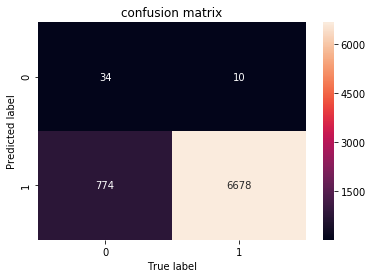

**********************************************************************

TNR= 0.04207920792079208
TPR= 0.9985047846889952
FPR= 0.9579207920792079
FNR= 0.0014952153110047847
**********************************************************************

             precision    recall  f1-score   support

          0       0.04      0.77      0.08        44
          1       1.00      0.90      0.94      7452

avg / total       0.99      0.90      0.94      7496

**********************************************************************



In [56]:
accu, TNR, TPR, FPR, FNR=svm_plot(clf=clf, x_train=vectors, y_train=y_train_word, x_test=x_test_word, y_test=y_test_word)

## Applying GridSearchCV on SGDClassifier

In [63]:
from sklearn.linear_model import SGDClassifier

tscv=TimeSeriesSplit(n_splits=10)
penalty=['l1', 'l2']
param={'alpha': [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50], 'penalty':penalty}
clf=SGDClassifier()
clf=GridSearchCV(estimator=clf, param_grid=param, cv=tscv,  n_jobs=1, verbose=1)

In [64]:
# fitting the model
import pickle
%time
start=datetime.now()
clf.fit(vectors,y_train_word)
pickle.dump(clf,open('svmlin_avg_grid.p','wb'))
end=datetime.now()
print('duration = ',(end-start))


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.6 µs
Fitting 10 folds for each of 28 candidates, totalling 280 fits
duration =  0:00:25.152163


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:   25.0s finished


In [65]:
# best value of C
penalty=clf.best_estimator_.get_params()['penalty']
alpha=clf.best_estimator_.get_params()['alpha']
print('best alpha=',alpha)
print('best penalty=',penalty)

best alpha= 0.0001
best penalty= l2


accuracy= 89.66115261472785
**********************************************************************

confusion matrix--


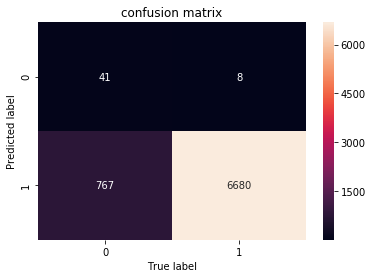

**********************************************************************

TNR= 0.050742574257425746
TPR= 0.9988038277511961
FPR= 0.9492574257425742
FNR= 0.0011961722488038277
**********************************************************************

             precision    recall  f1-score   support

          0       0.05      0.84      0.10        49
          1       1.00      0.90      0.95      7447

avg / total       0.99      0.90      0.94      7496

**********************************************************************



In [66]:
accu, TNR, TPR, FPR, FNR=svm_plot(clf=clf, x_train=vectors, y_train=y_train_word, x_test=x_test_word, y_test=y_test_word)

## Performance Table

| sno | featurization | model algo | cv algo | best C | best gamma | accuracy | TNR | TPR | f1-score |
|-----|----------------|---------------|--------------------|-------------|------------|----------|--------|--------|----------|
| 1 | Avg word2vec | SVC | GridSearchCV | 5 | 1 | 90.8084 | 0.25 | 0.9875 | 0.93 |
| 2 | Avg word2vec | SVC | RandomizedSearchCV | 50 | 10 | 89.5410 | 0.0420 | 0.9985 | 0.94 |


| sno | featurization | model algo | cv algo | best alpha | best penalty | accuracy | TNR | TPR | f1-score |
|-----|---------------|---------------|--------------|------------|--------------|----------|--------|--------|----------|
| 1 | Avg word2vec | SGDClassifier | GridSearchCV | 0.0001 | l2 | 89.6611 | 0.0507 | 0.9988 | 0.94 |

## Observation-
* Both SVC and SGDClassifier having same accuracy
* TNR is bad